# Import libraries

In [ ]:
# https://arxiv.org/abs/2101.12355v2
# https://bmirds.github.io/MHIST/
# https://github.com/BMIRDS/deepslide - deep learning framework for this kind of analysis

# The annotations for the images are the voting from the 7 doctors. X/7 means X of them believe that the image is SSA (cancerous).
    # Can I use this information instead of just 1/0?
# The researcher used ResNet-18, with and without pretraining
# torchvision is kind of the gold standard for models, but timm may have newer stuff
# huggingface (transformers) is another library for models, but it's more expansive (started off as a library for NLP). torchvision is widely used for CV.

# Misc - LR scheduler, prediction speed, training speed, original image size?, decision threshold - change it to minimize false negatives?

# Weighting the positive samples didn't seem to help (used 0.71/0.29) - try more extreme weight
# Researcher also tried removing the hardest images to classify - is it better to remove these before the train/val split or after?
    # DeepSlide github
# Double-check the AUC calculation
# Try balancing the dataset
# Try earlystopping with f1 - not sure about this one


In [1]:
import sys
print(sys.executable)

/home/ryanwtsai/repos/ml_ai_portfolio/mhist/venv/bin/python


In [3]:
# Libraries

import pickle
import random
import re
# import cv2
import skimage
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
from torch import nn
from torch.nn import BCELoss, CrossEntropyLoss
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import StepLR, LambdaLR
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
#from torchvision import transforms
#from torchvision.transforms import InterpolationMode
import torchvision.transforms.v2 as transforms
from torchvision.transforms.v2 import InterpolationMode
import torchmetrics
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, Specificity, AUROC, ROC
import timm

Train dataset: 71% HP
Test dataset: 63% HP

In [4]:
# Random seed

torch.manual_seed(42)
torch.cuda.manual_seed(42)
#torch.cuda.manual_seed_all(42)  # if you are using multi-GPU.

np.random.seed(42)

random.seed(42)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [16]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Load dataset and generate data splits

No validation; use all data for training
Remove images: [3.0, 4.0]
Training distribution: 1815 samples, 73.6% HP, 26.4% SSA
Test distribution: 977 samples, 63.2% HP, 36.8% SSA


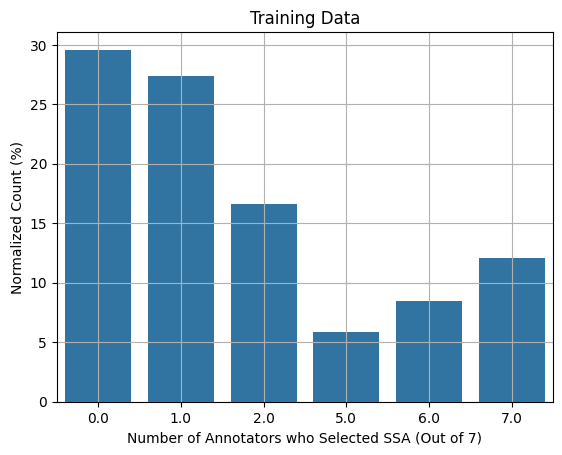

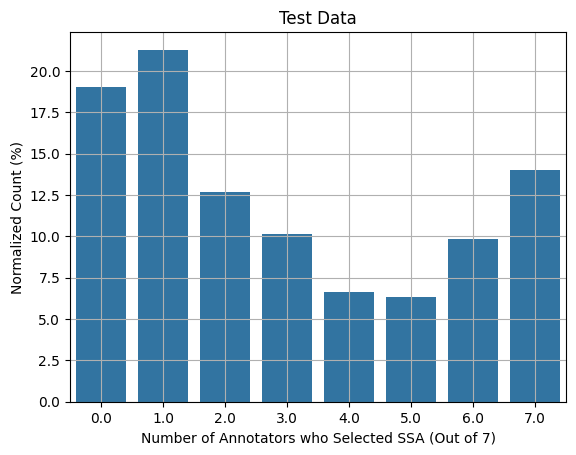

In [5]:
# Load dataset and check for issues in annotations.csv

# val_type = 'holdout'
# val_type = 'crossval'
val_type = None

# remove_images = None
# remove_images = [3.0]
remove_images = [3.0, 4.0]
# remove_images = [4.0]

image_path = 'dataset/images/'
anno_file = 'dataset/annotations.csv'
df = pd.read_csv(anno_file)

df['Image Name'] = image_path + df['Image Name']
label_map = {'SSA': 1, 'HP': 0}
df['Majority Vote Label'] = df['Majority Vote Label'].map(label_map)

int64_cols = df.select_dtypes(include='int64').columns
df[int64_cols] = df[int64_cols].astype('float32')

df_train = df.loc[df['Partition'] == 'train']
df_test = df.loc[df['Partition'] == 'test']

# Train-val split
if val_type == 'holdout' or val_type == None:
    if val_type == 'holdout':
        print('Holdout validation')
        #df_train, df_val, _, _ = train_test_split(df_train, df_train['Majority Vote Label'], test_size=0.2, stratify=df_train['Majority Vote Label'])
        df_train, df_val, _, _ = train_test_split(df_train, df_train['Majority Vote Label'], test_size=0.2, stratify=df_train['Number of Annotators who Selected SSA (Out of 7)'])
    elif val_type == None:
        print('No validation; use all data for training')
        
    # Remove images where only 4/7 annotators agreed
    if remove_images != None:
        print('Remove images:', remove_images)
        df_train = df_train[~df_train['Number of Annotators who Selected SSA (Out of 7)'].isin(remove_images)]

    hp_perc = (df_train['Majority Vote Label'] == 0).sum()/len(df_train)*100
    hp_ssa = (df_train['Majority Vote Label'] == 1).sum()/len(df_train)*100
    pos_weight = hp_perc/hp_ssa # in case weighting is desired
    print('Training distribution: ' + str(len(df_train)) + ' samples, ' + str(round(hp_perc,1)) + '% HP, ' + str(round(hp_ssa,1)) + '% SSA')
    
    if val_type == 'holdout':
        hp_perc = (df_val['Majority Vote Label'] == 0).sum()/len(df_val)*100
        hp_ssa = (df_val['Majority Vote Label'] == 1).sum()/len(df_val)*100
        print('Validation distribution: ' + str(len(df_val)) + ' samples, ' + str(round(hp_perc,1)) + '% HP, ' + str(round(hp_ssa,1)) + '% SSA')
        
    hp_perc = (df_test['Majority Vote Label'] == 0).sum()/len(df_test)*100
    hp_ssa = (df_test['Majority Vote Label'] == 1).sum()/len(df_test)*100
    print('Test distribution: ' + str(len(df_test)) + ' samples, ' + str(round(hp_perc,1)) + '% HP, ' + str(round(hp_ssa,1)) + '% SSA')
    
    grouped = df_train['Number of Annotators who Selected SSA (Out of 7)'].value_counts()
    plt.figure()
    sns.barplot(x = grouped.index, y = grouped/len(df_train)*100)
    plt.ylabel('Normalized Count (%)')
    plt.title('Training Data')
    plt.grid()

    if val_type == 'holdout':
        grouped = df_val['Number of Annotators who Selected SSA (Out of 7)'].value_counts()
        plt.figure()
        sns.barplot(x = grouped.index, y = grouped/len(df_val)*100)
        plt.ylabel('Normalized Count (%)')
        plt.title('Validation Data')
        plt.grid()
    
    grouped = df_test['Number of Annotators who Selected SSA (Out of 7)'].value_counts()
    plt.figure()
    sns.barplot(x = grouped.index, y = grouped/len(df_test)*100)
    plt.ylabel('Normalized Count (%)')
    plt.title('Test Data')
    plt.grid()
elif val_type == 'crossval':
    skf = StratifiedKFold(n_splits=10)
    kfolds = skf.split(np.zeros(len(df_train)), df_train['Number of Annotators who Selected SSA (Out of 7)'])
    kfolds = [[train_index, test_index] for train_index, test_index in kfolds]
    # Remove images where only 4/7 annotators agreed
    for i, (train_index, test_index) in enumerate(kfolds):
        df_train_fold = df_train.iloc[train_index]
        train_index = train_index[~df_train_fold['Number of Annotators who Selected SSA (Out of 7)'].isin([3.0, 4.0])]
        #train_index = train_index[~df_train_fold['Number of Annotators who Selected SSA (Out of 7)'].isin([3.0])]
        #train_index = train_index[~df_train_fold['Number of Annotators who Selected SSA (Out of 7)'].isin([4.0])]
        kfolds[i][0] = train_index
        
    for i, (train_index, test_index) in enumerate(kfolds):
        print(f"Fold {i}:")
        df_train_fold = df_train.iloc[train_index]
        df_val_fold = df_train.iloc[test_index]

        # Remove images where only 4/7 annotators agreed
        #df_train_fold = df_train_fold[~df_train_fold['Number of Annotators who Selected SSA (Out of 7)'].isin([3.0, 4.0])]
        #df_train_fold = df_train_fold[~df_train_fold['Number of Annotators who Selected SSA (Out of 7)'].isin([4.0])]
        #df_train_fold = df_train_fold[~df_train_fold['Number of Annotators who Selected SSA (Out of 7)'].isin([3.0])]
        
        print('Training size, val size:', len(df_train_fold), ',', len(df_val_fold))
        df_train_fold = np.round(df_train_fold['Number of Annotators who Selected SSA (Out of 7)'].value_counts()/len(df_train_fold)*100,1)
        df_val_fold = np.round(df_val_fold['Number of Annotators who Selected SSA (Out of 7)'].value_counts()/len(df_val_fold)*100,1)
        df_concat = pd.concat((df_train_fold, df_val_fold), axis=1)
        print(df_concat)
        print('\n')
else:
    raise Exception('Need to select validation type')



# print(df.info())
# print('-----------------------------------------')
# print(df['Majority Vote Label'].value_counts())
# print('-----------------------------------------')
# print(df['Partition'].value_counts())
# print('-----------------------------------------')
# print(df['Number of Annotators who Selected SSA (Out of 7)'].value_counts())
# print('-----------------------------------------')
# df.head(3)

# print('-----------------------------------------')
# print(df_train.info())
# print('-----------------------------------------')
# print(df_train['Majority Vote Label'].value_counts())
# print('-----------------------------------------')
# print(df_train['Partition'].value_counts())
# print('-----------------------------------------')

# print('-----------------------------------------')
# print(df_test.info())
# print('-----------------------------------------')
# print(df_test['Majority Vote Label'].value_counts())
# print('-----------------------------------------')
# print(df_test['Partition'].value_counts())
# print('-----------------------------------------')

# Define (PyTorch) Dataset subclasses

In [6]:
# Baseline dataset (supports binary and multiclass classification)

class MHIST(Dataset):
    def __init__(self, dataset_df, label_name='Majority Vote Label', transform=None, target_transform=None):
        self.img_labels = dataset_df[label_name]
        self.img_paths = dataset_df['Image Name']
        self.transform = transform
        self.target_transform = target_transform
        self.annotator_counts = dataset_df['Number of Annotators who Selected SSA (Out of 7)']
        self.num_classes = len(self.img_labels.value_counts())

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_paths.iloc[idx]
        image = skimage.io.imread(img_path)
        label = self.img_labels.iloc[idx]
        anno_count = self.annotator_counts.iloc[idx]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        output = {"image": image, "label": label, "image_path": img_path, "anno_count": anno_count}
        return output

# labels = []
# image_paths = []
# train_loader = DataLoader(MHIST(df_test), batch_size=16, shuffle=True)
# for i, batch in enumerate(train_loader):
#     images = batch['image']
#     labels += batch['label']
#     image_paths += batch['image_path']

# len(labels)

In [7]:
# Dataset for oversampling training data for binary classification

class MHIST_OverSampled(Dataset):
    def __init__(self, dataset_df, transform=None, transform_augment=None, algo='RandomOverSampler', augment_all=False):
        self.img_labels = dataset_df['Majority Vote Label']
        self.img_paths = dataset_df['Image Name']
        self.annotator_counts = dataset_df['Number of Annotators who Selected SSA (Out of 7)']
        self.transform = transform
        self.transform_augment = transform_augment
        self.augment_all = augment_all # if True, then augment all samples

        # 'RandomOverSampler' - randomly oversample minority class
        # 'SMOTE' - randomly oversample minority class. Apply augmentation to oversamples.
        # 'ADASYN' - oversample only the most difficult minority class samples. Apply augmentation to oversamples.
        self.algo = algo

        # Get minority class label
        label_counts = self.img_labels.value_counts()
        self.minority_class = label_counts.index[label_counts == label_counts.min()].item()

        # Get class indices
        self.minority_indices = np.array(dataset_df.index[self.img_labels == self.minority_class])
        self.majority_indices = np.array(dataset_df.index[self.img_labels != self.minority_class])
        self.num_minority = len(self.minority_indices)
        self.num_majority = len(self.majority_indices)

        # Get the most difficult minority samples
        self.difficulty_count = self.annotator_counts.loc[self.img_labels == self.minority_class].value_counts().index.min()
        self.minority_difficult_indices = np.array(dataset_df.index[self.annotator_counts == self.difficulty_count])
    
    def __len__(self):
        return 2*self.num_majority
    
    def __getitem__(self, idx):
        # Get index
        augment = False
        if idx < self.num_majority: # majority class
            idx = self.majority_indices[idx]
        elif idx < self.num_majority+self.num_minority: # minority class
            idx = self.minority_indices[idx-self.num_majority]
        else: # oversampling
            if self.algo == 'RandomOverSampler':
                idx = random.choice(self.minority_indices) # select any minority sample
            elif self.algo == 'SMOTE':
                idx = random.choice(self.minority_indices) # select any minority sample
                augment = True
            elif self.algo == 'ADASYN':
                idx = random.choice(self.minority_difficult_indices) # select a difficult minority sample
                augment = True
            else:
                raise Exception('Invalid algo selected')

        # Load sample
        #img_path = self.img_paths.iloc[idx]
        #label = self.img_labels.iloc[idx]
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]
        anno_count = self.annotator_counts[idx]
        
        
        image = skimage.io.imread(img_path)

        if (self.augment_all or augment) and self.transform_augment:
            image = self.transform_augment(image)
        elif self.transform:
            image = self.transform(image)

        output = {"image": image, "label": label, "image_path": img_path, "anno_count": anno_count}
        return output
        

In [8]:
# Dataset for oversampling training data for multiclass classification

class MHIST_OverSampled_MultiClass(Dataset):
    def __init__(self, dataset_df, transform=None, transform_augment=None, algo='RandomOverSampler', augment_all=False):
        self.img_labels = dataset_df['Number of Annotators who Selected SSA (Out of 7)']
        self.img_paths = dataset_df['Image Name']
        self.annotator_counts = dataset_df['Number of Annotators who Selected SSA (Out of 7)']
        self.transform = transform
        self.transform_augment = transform_augment
        self.augment_all = augment_all # if True, then augment all samples

        # 'RandomOverSampler' - randomly oversample minority class
        self.algo = algo

        # Get class distributions and majority class label
        label_counts = self.img_labels.value_counts()
        label_counts = label_counts.sort_index()
        num_majority = label_counts.max()
        majority_class = label_counts.index[label_counts == num_majority].item()

        # Get label indices
        class_indices = []
        for i in label_counts.index:
            class_indices.append(np.array(dataset_df.index[self.img_labels == i]))

        # Get thresholds
        thresholds1 = num_majority*np.array(range(len(label_counts)))
        thresholds2 = np.array(label_counts+thresholds1)
        thresholds = np.concatenate((thresholds1, thresholds2))
        thresholds = np.sort(thresholds)

        # Save state variables
        self.label_counts = label_counts
        self.num_classes = len(label_counts)
        self.num_majority = num_majority
        self.majority_class = majority_class
        self.class_indices = class_indices
        self.thresholds = thresholds
    
    def __len__(self):
        return self.len(label_counts)*self.num_majority
    
    def __getitem__(self, idx):
        # Get index
        augment = False
        if idx < self.num_majority: # majority class
            idx = self.majority_indices[idx]
        elif idx < self.num_majority+self.num_minority: # minority class
            idx = self.minority_indices[idx-self.num_majority]
        else: # oversampling
            if self.algo == 'RandomOverSampler':
                idx = random.choice(self.minority_indices) # select any minority sample
            elif self.algo == 'SMOTE':
                idx = random.choice(self.minority_indices) # select any minority sample
                augment = True
            elif self.algo == 'ADASYN':
                idx = random.choice(self.minority_difficult_indices) # select a difficult minority sample
                augment = True
            else:
                raise Exception('Invalid algo selected')

        # Find where idx >= thresholds[i]. i is the maximum
        # If i is even, then the class is i/2. Pick img.iloc[indices[i/2][idx-(i/2-1)*num_majority]]
        # If i is odd, then the class is (i-1)/2. Then pick a random index from indices[i/2].
        i = np.where(idx >= self.thresholds)[0].max()
        if i % 2 == 0:
            i = round(i/2)
            idx = self.class_indices[i][idx - (i-1)*self.num_majority]
        else:
            i = round((i-1)/2)
            idx = random.choice(self.class_indices[i])
            
        # Load sample
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]
        anno_count = self.annotator_counts[idx]

        image = skimage.io.imread(img_path)

        if (self.augment_all or augment) and self.transform_augment:
            image = self.transform_augment(image)
        elif self.transform:
            image = self.transform(image)

        output = {"image": image, "label": label, "image_path": img_path, "anno_count": anno_count}
        return output

Preprocessing (documentation from torchvision)

The inference transforms are available at ResNet18_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: 
Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. 
The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, 
followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] 
and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

In [ ]:
(224*224*3*1024 + 1025*512 + 513*256 + 257*128 + 129)/1e6
11.7e6 / (224*224*3)
((224*224*3+1)*128 + 127*64 + 65*32 + 33)/1e6

# Instantiate model

In [9]:
# Define FCNN
# 224*224*3 -> 128 -> 64 -> 32 -> 1

class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        # Assume input size is 224x224x3
        self.fc1 = nn.Linear(224 * 224 * 3, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 64)             # Second fully connected layer
        self.fc3 = nn.Linear(64, 32)              # Third fully connected layer
        self.fc4 = nn.Linear(32, 1)               # Output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x
        

In [12]:
# Instantiate the model

model_type = 'ResNet-18'
model_type = 'ViT-Base Patch16/224'
# model_type = 'FCNN'

pretrain = True

class_task = 'binary'
#class_task = 'multiclass'

# Instantiate model
if model_type == 'ResNet-18':
    weights = ResNet18_Weights.DEFAULT
    if pretrain:
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
    else:
        model = resnet18()
    
    if class_task == 'binary':
        model.fc = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    elif class_task == 'multiclass':
        model.fc = nn.Sequential(
            nn.Linear(512, train_loader.dataset.num_classes),
        )
    print('Modified ResNet-18.fc:')
    print(model.fc)
    
elif model_type == 'ViT-Base Patch16/224':
    model = timm.create_model('vit_base_patch16_224', pretrained=pretrain)

    if class_task == 'binary':
        model.head = nn.Sequential(
            nn.Linear(768, 1),
            nn.Sigmoid()
        )
    elif class_task == 'multiclass':
        model.head = nn.Sequential(
            nn.Linear(768, train_loader.dataset.num_classes),
        )
        model.fc = nn.Sequential(
            nn.Linear(512, train_loader.dataset.num_classes),
        )
    print('Modified ViT-Base Patch16/224.head:')
    print(model.head)

elif model_type == 'FCNN':
    model = FCNN()
    print('Fully connected neural network')
    
    #data_config = timm.data.resolve_model_data_config(model)
    #transforms = timm.data.create_transform(**data_config, is_training=True)

Modified ViT-Base Patch16/224.head:
Sequential(
  (0): Linear(in_features=768, out_features=1, bias=True)
  (1): Sigmoid()
)


In [14]:
type(model)

timm.models.vision_transformer.VisionTransformer

In [13]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# DataLoaders, image transforms/augmentations

In [81]:
# DataLoaders

# oversample = None
oversample = 'RandomOverSampler'
#oversample = 'SMOTE'
#oversample = 'ADASYN'

augment_all = True
# augment_all = False

if model_type == 'ResNet-18':
    batch_size = 32 # from paper
elif model_type == 'ViT-Base Patch16/224':
    batch_size = 8 # guess
elif model_type == 'FCNN':
    batch_size = 32




if model_type == 'ResNet-18':
    prenorm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
elif model_type == 'ViT-Base Patch16/224':
    prenorm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
elif model_type == 'FCNN':
    prenorm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize pixel values to range [-1, +1]


# ResNet-18 - MHIST images are already 224x224; paper says they can be fed directly into the model without resizing
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize(size=256, interpolation=InterpolationMode.BILINEAR),
    #transforms.CenterCrop(224),
    prenorm,
])

# # Flip
# transform_augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])

# # Rotate
# transform_augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomApply([transforms.RandomRotation(degrees=180, expand=True),
#                             transforms.Resize(size=224, interpolation=InterpolationMode.BILINEAR)], p=0.5),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])

# Flip+rotate
transform_augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=180, expand=True),
                            transforms.Resize(size=224, interpolation=InterpolationMode.BILINEAR)], p=0.5),
    transforms.ToTensor(),
    prenorm,
])

# # Perspective
# transform_augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomPerspective(distortion_scale=0.5, interpolation=InterpolationMode.BILINEAR, p=0.5),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])

# # Affine
# transform_augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1,0.1), shear=(-15,15,-15,15), 
#                                                     scale=(0.5,0.55), interpolation=InterpolationMode.BILINEAR),
#                            ], p=0.5),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])

# # Flip, (rotate/perspective/affine)
# transform_augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomChoice([
#         transforms.RandomApply([transforms.RandomRotation(degrees=180, expand=True),
#                                 transforms.Resize(size=224, interpolation=InterpolationMode.BILINEAR)], p=0.5),
#         transforms.RandomPerspective(distortion_scale=0.5, interpolation=InterpolationMode.BILINEAR, p=0.5),
#         transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1,0.1), shear=(-15,15,-15,15), 
#                                                     scale=(0.5,0.55), interpolation=InterpolationMode.BILINEAR)], p=0.5),
#     ]),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])

val_loader = None
if class_task == 'binary':
    #train_loader = DataLoader(MHIST(df_train, transform=transform), batch_size=batch_size, shuffle=True)
    if oversample == None:
        train_loader = DataLoader(MHIST(df_train, label_name='Majority Vote Label', transform=transform_augment), batch_size=batch_size, shuffle=True)
    else:
        train_loader = DataLoader(MHIST_OverSampled(df_train, transform=transform, transform_augment=transform_augment, 
                                                    algo=oversample, augment_all=augment_all), batch_size=batch_size, shuffle=True)

    if val_type != None:
        val_loader = DataLoader(MHIST(df_val, label_name='Majority Vote Label', transform=transform), batch_size=batch_size, shuffle=False)

    test_loader = DataLoader(MHIST(df_test, label_name='Majority Vote Label', transform=transform), batch_size=batch_size, shuffle=False)
elif class_task == 'multiclass':  
    if oversample == None:
        train_loader = DataLoader(MHIST(df_train, label_name='Number of Annotators who Selected SSA (Out of 7)', transform=transform_augment), 
                                  batch_size=batch_size, shuffle=True)
    else:
        train_loader = DataLoader(MHIST_OverSampled_MultiClass(df_train, transform=transform, transform_augment=transform_augment, 
                                                    algo='RandomOverSampler', augment_all=augment_all), batch_size=batch_size, shuffle=True)

    if val_type != None:
        val_loader = DataLoader(MHIST(df_val, label_name='Number of Annotators who Selected SSA (Out of 7)', transform=transform), 
                                batch_size=batch_size, shuffle=False)

    test_loader = DataLoader(MHIST(df_test, label_name='Number of Annotators who Selected SSA (Out of 7)', transform=transform), 
                             batch_size=batch_size, shuffle=False)

#test_loader = DataLoader(MHIST(df_test, transform=transform), batch_size=batch_size, shuffle=False)

batch = next(iter(train_loader))
image = batch['image']
label = batch['label']

print(image.shape)
print(label.shape)
print(torch.min(image))
print(torch.max(image))
print(torch.mean(image))

# C:\ProgramData\anaconda3\envs\env_dl_cv_transformer\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: 
# UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. 
# Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
#   warnings.warn(

C:\ProgramData\anaconda3\envs\env_dl_cv_transformer\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


torch.Size([32, 3, 224, 224])
torch.Size([32])
tensor(-2.1179)
tensor(2.6400)
tensor(0.6605)


In [10]:
print('Model type:', model_type)
print('Batch size:', train_loader.batch_size)
print('')

print('Transform:')
print(train_loader.dataset.transform)
print('')
if hasattr(train_loader.dataset, 'transform_augment'):
    print('Transform with augmentation:')
    print(train_loader.dataset.transform_augment)
    print('')
if hasattr(train_loader.dataset, 'num_classes'):
    print('Num classes:', train_loader.dataset.num_classes)
if hasattr(train_loader.dataset, 'algo'):
    print('Oversampling:', train_loader.dataset.algo)
if hasattr(train_loader.dataset, 'augment_all'):
    print('Augment all:', train_loader.dataset.augment_all)
if hasattr(train_loader.dataset, 'difficulty_count'):
    print('Most difficult minority class:', train_loader.dataset.difficulty_count)
if hasattr(train_loader.dataset, 'minority_difficult_indices'):
    print('Number of difficult samples:', len(train_loader.dataset.minority_difficult_indices))
print('Sampler:')
print(train_loader.sampler)

Model type: FCNN
Batch size: 32

Transform:
Compose(
      ToTensor()
      Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
)

Transform with augmentation:
Compose(
      ToPILImage()
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.5)
      RandomApply(
        RandomRotation(degrees=[-180.0, 180.0], interpolation=InterpolationMode.NEAREST, expand=True, fill=0)
        Resize(size=[224], interpolation=InterpolationMode.BILINEAR, antialias=True)
  )
      ToTensor()
      Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
)

Oversampling: RandomOverSampler
Augment all: True
Most difficult minority class: 5.0
Number of difficult samples: 106
Sampler:


In [ ]:
# # From ChatGPT

# header = ['Epoch', 'LR', 'T Loss', 'V Loss']
# col_widths = [max(len(col), 10) for col in header]
# # Create a format string based on column widths
# format_str = '  '.join([f"{{:<{width}}}" for width in col_widths])

# # Print the header
# print(format_str.format(*header))

# # Print a separator
# print('-' * sum(col_widths) + '-' * (2 * (len(col_widths) - 1)))

# metric_results = np.zeros(len(header))

# Define EarlyStopping class

In [11]:
# Define EarlyStopping class

class EarlyStopping:
    def __init__(self, patience=10, delta=0.01, lowerisbetter=True):
        self.patience = patience
        self.delta = delta # relative delta
        self.lowerisbetter = lowerisbetter
        self.counter = 0 # keep track of how many epochs have passed without improvement
        self.best_score = None # best validation loss
        self.best_state = None # model state with the best loss
        self.best_epoch = None # epoch with the best loss
        self.early_stop = False # if True, then stop training

    def __call__(self, score, model, epoch):
        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            self.best_epoch = epoch
        elif self.lowerisbetter and score < self.best_score*(1-self.delta):
            self.best_score = score
            self.best_state = model.state_dict()
            self.best_epoch = epoch
            self.counter = 0
        elif not(self.lowerisbetter) and score > self.best_score*(1+self.delta):
            self.best_score = score
            self.best_state = model.state_dict()
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Define training function

In [12]:
# Training function

def train(output, class_task, train_loader, model, cost_function, optimizer, 
          max_epochs=1, metrics=[], val_loader=None, earlystop=None, lrschedule=None, pos_weight=None, grad_accum=1):
    # class_task (str) - 'binary' or 'multiclass'
    # train_loader (object) - training dataloader
    # model (object) - neural network
    # cost_function (object) - cost function
    # optimizer (object) - gradient descent
    # max_epochs (int) - number of epochs
    # metrics (list of objects) - torchvision metrics
    # val_loader (object) - validation dataloader
    # earlystop (object) - for early stopping
    # lrschedule (object) - for LR scheduling
    # grad_accum (positive integer) - to accumulate training results over grad_accum batches before updating parameters

    device = next(iter(model.parameters())).device

    #output = {'T Loss': []}
    output['T Loss'] = []
    if val_loader != None:
        output['V Loss'] = []
    for metric in metrics:
        metric.to(device)
        output['T ' + metric.__class__.__name__] = []
        if val_loader != None:
            output['V ' + metric.__class__.__name__] = []

    # Print header
    max_num = 6
    if val_loader != None:
        max_met = (max_num-2)/2
        max_met = int(max_met)
    else:
        max_met = max_num
    header = ['Epoch', 'LR'] + list(output.keys())[:max_num]
    col_widths = [max(len(col), 10) for col in header]
    format_str = '  '.join([f"{{:<{width}}}" for width in col_widths])
    print(format_str.format(*header))
    print('-' * sum(col_widths) + '-' * (2 * (len(col_widths) - 1)))

    num0 = 0
    num1 = 0
    anno_counts = {0: 0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
    for epoch in range(1, max_epochs+1):
        # Reset metrics
        for metric in metrics:
            metric.reset()
        
        # Training
        model.train()
        cum_cost = 0
        grad_accum_counter = 0
        for bdx, batch in enumerate(train_loader):
            X = batch['image']
            y = batch['label']
            num0 += torch.sum(y == 0)
            num1 += torch.sum(y == 1)

            if 'anno_count' in batch:
                anno_count = batch['anno_count']
                anno_counts[0] += torch.sum(anno_count == 0)
                anno_counts[1] += torch.sum(anno_count == 1)
                anno_counts[2] += torch.sum(anno_count == 2)
                anno_counts[3] += torch.sum(anno_count == 3)
                anno_counts[4] += torch.sum(anno_count == 4)
                anno_counts[5] += torch.sum(anno_count == 5)
                anno_counts[6] += torch.sum(anno_count == 6)
                anno_counts[7] += torch.sum(anno_count == 7)

            # Forward pass
            X, y = X.to(device), y.to(device)
            y_hat = model.forward(X)
            if class_task == 'binary':
                y_hat = torch.squeeze(y_hat)

            # Calculate cost/loss
            if not(pos_weight == None):
                # Not updated for multiclass
                cost_function.reduction = 'none'
                cost = cost_function(y_hat, y)
                #print(cost.mean())
                #print(cost.shape)
                weight = torch.where(y == 1, torch.tensor(pos_weight*1.0), torch.tensor(1.0))
                #print(weight.shape)
                weighted_cost = (cost*weight).mean()
                #print(weighted_cost)
                cost = weighted_cost
                cost_function.reduction = 'mean'
            else:
                if class_task == 'binary':
                    cost = cost_function(y_hat, y)
                elif class_task == 'multiclass':
                    cost = cost_function(y_hat, y.long())
            cum_cost += cost.detach().item()

            # Calculate gradients
            cost.backward()

            # Update parameters
            grad_accum_counter += 1
            if grad_accum_counter == grad_accum:
                optimizer.step()
                grad_accum_counter = 0
                optimizer.zero_grad()

            # Update metrics
            if class_task == 'binary':
                y_pred = torch.round(y_hat)
            elif class_task == 'multiclass':
                _, y_pred = torch.max(y_hat, 1)
            for metric in metrics:
                if metric.__class__.__name__ == 'BinaryROC':
                    y_pred = y_hat
                    metric.update(y_pred, y.long())
                else:
                    metric.update(y_pred, y)

        # Handle the final gradient step if there are remaining accumulated gradients
        if grad_accum_counter > 0:
            optimizer.step()
            optimizer.zero_grad()
        
        output['T Loss'].append(cum_cost)
        for metric in metrics:
            if metric.__class__.__name__ == 'BinaryROC':
                fpr, tpr, thresholds = metric.compute()
                auc = torch.trapz(tpr, fpr)
                output['T ' + metric.__class__.__name__].append(auc.cpu().numpy())
            else:
                output['T ' + metric.__class__.__name__].append(metric.compute().detach().cpu().numpy())
        
        # Validation
        if not(val_loader == None):
            val_output = predict(class_task, val_loader, model, cost_function, metrics=metrics, pos_weight=pos_weight)
            #output.update({'V ' + key: value for key, value in val_output.items()})
            for key in val_output:
                if 'V ' + key in output:
                    output['V ' + key].append(val_output[key])

        # Print metrics
        epoch_results = []
        epoch_results.append(epoch)
        if lrschedule != None:
            epoch_results.append(round(lrschedule.get_last_lr()[-1], 8))
        else:
            epoch_results.append('lr_init')
        epoch_results.append(round(output['T Loss'][-1],1))
        if val_loader != None:
            epoch_results.append(round(output['V Loss'][-1],1))
        for mdx in range(min(len(metrics),max_met)):
            metric = metrics[mdx]
            epoch_results.append(round(output['T ' + metric.__class__.__name__][-1].item(),3))
            if val_loader != None:
                epoch_results.append(round(output['V ' + metric.__class__.__name__][-1].item(),3))
        print(format_str.format(*epoch_results))

        # Early stop
        if not(earlystop == None) and not(val_loader == None):
            # Use validation AUC if available, else validation loss

            if class_task == 'binary':
                if 'V BinaryROC' in output:
                    earlystop(output['V BinaryROC'][-1].item(), model, epoch)
                elif 'V BinaryF1Score' in output:
                    earlystop(output['V BinaryF1Score'][-1].item(), model, epoch)
                else:
                    earlystop(cum_cost, model, epoch)
            elif class_task == 'multiclass':
                if 'V MulticlassF1Score' in output:
                    earlystop(output['V MulticlassF1Score'][-1].item(), model, epoch)
                else:
                    earlystop(cum_cost, model, epoch)
                
            if earlystop.early_stop:
                print('Early stop triggered. Loading best model state from epoch ', earlystop.best_epoch, '.')
                model = model.load_state_dict(earlystop.best_state) # load optimum parameters
                break

        # Update learning rate
        if not(lrschedule == None):
            lrschedule.step()

    print('num0:', num0)
    print('num1:', num1)
    print('anno_counts:', anno_counts)
    output['Majority Sample Count'] = num0
    output['Minority Sample Count'] = num1
    output['Annotator Counts'] = anno_counts
    #return output

In [ ]:
# Cross-validation function

def crossval(kfolds, df_train, model, cost_function, optimizer, 
          max_epochs=1, metrics=[], earlystop=None, lrschedule=None, pos_weight=None):
    
    

In [ ]:
# Customer scheduler

def lr_lambda(epoch):
    if epoch < 6:
        return 1.0
    else:
        return 0.1

In [ ]:
# Train the model (10 seeds)

# model_type = 'ViT-Base Patch16/224'
# pretrain = True
# class_task = 'binary'
# weight_positives = False
# grad_accum = 1 # no gradient accumulation
# max_epochs = 15
# lr_init = 1e-5 # good for ViT
# weight_decay = None
# patience = 15
# oversample = 'RandomOverSampler'
# augment_all = True

# if model_type == 'ResNet-18':
#     batch_size = 32 # from paper
# elif model_type == 'ViT-Base Patch16/224':
#     batch_size = 8 # guess

# if model_type == 'ResNet-18':
#     prenorm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# elif model_type == 'ViT-Base Patch16/224':
#     prenorm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# # ResNet-18 - MHIST images are already 224x224; paper says they can be fed directly into the model without resizing
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     #transforms.Resize(size=256, interpolation=InterpolationMode.BILINEAR),
#     #transforms.CenterCrop(224),
#     prenorm,
# ])

# # Flip+rotate
# transform_augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomApply([transforms.RandomRotation(degrees=180, expand=True),
#                             transforms.Resize(size=224, interpolation=InterpolationMode.BILINEAR)], p=0.5),
#     transforms.ToTensor(),
#     prenorm,
# ])

# if pretrain:
#     print(model_type + ', pretrained weights')
# else:
#     print(model_type + ', randomly initialized weights')

# randseeds = [860, 270, 106,  71, 700,  20, 614]
# for randseed in randseeds:
#     print('randseed: ', randseed)
#     torch.manual_seed(randseed)
#     torch.cuda.manual_seed(randseed)
#     np.random.seed(randseed)
#     random.seed(randseed)

#     print('Model state will be saved to ' + 'model221-nv-rs' + str(randseed) + '.pth')
#     print('Training results will be saved to ' + 'model221-nv-rs' + str(randseed) + '_train_results.pkl')

#     # Instantiate model
#     if model_type == 'ResNet-18':
#         weights = ResNet18_Weights.DEFAULT
#         if pretrain:
#             model = resnet18(weights=ResNet18_Weights.DEFAULT)
#         else:
#             model = resnet18()
        
#         if class_task == 'binary':
#             model.fc = nn.Sequential(
#                 nn.Linear(512, 1),
#                 nn.Sigmoid()
#             )
#         elif class_task == 'multiclass':
#             model.fc = nn.Sequential(
#                 nn.Linear(512, train_loader.dataset.num_classes),
#             )
#         print('Modified ResNet-18.fc:')
#         print(model.fc)
        
#     elif model_type == 'ViT-Base Patch16/224':
#         model = timm.create_model('vit_base_patch16_224', pretrained=pretrain)
    
#         if class_task == 'binary':
#             model.head = nn.Sequential(
#                 nn.Linear(768, 1),
#                 nn.Sigmoid()
#             )
#         elif class_task == 'multiclass':
#             model.head = nn.Sequential(
#                 nn.Linear(768, train_loader.dataset.num_classes),
#             )
#             model.fc = nn.Sequential(
#                 nn.Linear(512, train_loader.dataset.num_classes),
#             )
#         print('Modified ViT-Base Patch16/224.head:')
#         print(model.head)

#     # DataLoaders
#     val_loader = None
#     if class_task == 'binary':
#         #train_loader = DataLoader(MHIST(df_train, transform=transform), batch_size=batch_size, shuffle=True)
#         if oversample == None:
#             train_loader = DataLoader(MHIST(df_train, label_name='Majority Vote Label', transform=transform_augment), batch_size=batch_size, shuffle=True)
#         else:
#             train_loader = DataLoader(MHIST_OverSampled(df_train, transform=transform, transform_augment=transform_augment, 
#                                                         algo=oversample, augment_all=augment_all), batch_size=batch_size, shuffle=True)
    
#         if val_type != None:
#             val_loader = DataLoader(MHIST(df_val, label_name='Majority Vote Label', transform=transform), batch_size=batch_size, shuffle=False)
    
#         test_loader = DataLoader(MHIST(df_test, label_name='Majority Vote Label', transform=transform), batch_size=batch_size, shuffle=False)
#     elif class_task == 'multiclass':  
#         if oversample == None:
#             train_loader = DataLoader(MHIST(df_train, label_name='Number of Annotators who Selected SSA (Out of 7)', transform=transform_augment), 
#                                       batch_size=batch_size, shuffle=True)
#         else:
#             train_loader = DataLoader(MHIST_OverSampled_MultiClass(df_train, transform=transform, transform_augment=transform_augment, 
#                                                         algo='RandomOverSampler', augment_all=augment_all), batch_size=batch_size, shuffle=True)
    
#         if val_type != None:
#             val_loader = DataLoader(MHIST(df_val, label_name='Number of Annotators who Selected SSA (Out of 7)', transform=transform), 
#                                     batch_size=batch_size, shuffle=False)
    
#         test_loader = DataLoader(MHIST(df_test, label_name='Number of Annotators who Selected SSA (Out of 7)', transform=transform), 
#                                  batch_size=batch_size, shuffle=False)
    
#     print('Effective batch size:', train_loader.batch_size*grad_accum)
    
#     # Training hyperparams
#     if model_type == 'ResNet-18':
#         optimizer = Adam(model.parameters(), lr=lr_init)
#         lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.91, last_epoch=-1) # from paper
#         print('Initial learning rate, step, decay:', lr_init, ',', 1, ',', 0.91)
        
#     elif model_type == 'ViT-Base Patch16/224':
#         if weight_decay == None:
#             optimizer = Adam(model.parameters(), lr=lr_init)
#             print('Adam optimizer')
#         else:
#             # optimizer = AdamW(model.parameters(), lr=lr_init)
#             optimizer = AdamW(model.parameters(), lr=lr_init, weight_decay=weight_decay)
#             print('AdamW optimizer, weight decay =', optimizer.param_groups[0]['weight_decay'])
    
#         print('Initial learning rate =', optimizer.param_groups[0]['lr'])
        
#         lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.91, last_epoch=-1) # from paper
#         print('LR step_size, gamma:', lr_scheduler.step_size, ',', lr_scheduler.gamma)
        
#         print('------------------------------------------------------------------------------------------------')
#         model.head_drop.p = 0.5
#         print('Modified head_drop:')
#         print(model.head_drop)
#         print('------------------------------------------------------------------------------------------------')

#     # Training setup
#     if class_task == 'binary':
#         cost_function = BCELoss()
#     elif class_task == 'multiclass':
#         cost_function = CrossEntropyLoss()
    
#     if val_loader != None:
#         earlystop = EarlyStopping(patience=patience, delta=0.01, lowerisbetter=False)
#     else:
#         earlystop = None
    
#     if class_task == 'binary':
#         precision = Precision(task='binary', average=None)
#         recall = Recall(task='binary', average=None)
#         accuracy = Accuracy(task='binary', average=None)
#         f1score = F1Score(task='binary', average=None)
#         specificity = Specificity(task='binary', average=None)
#         roc = ROC(task='binary')
#     elif class_task == 'multiclass':
#         precision = Precision(task='multiclass', num_classes=8, average='macro')
#         recall = Recall(task='multiclass', num_classes=8, average='macro')
#         accuracy = Accuracy(task='multiclass', num_classes=8, average='macro')
#         f1score = F1Score(task='multiclass', num_classes=8, average='macro')
#         specificity = Specificity(task='multiclass', num_classes=8, average='macro')
        
#     metrics = [f1score, recall, precision, specificity, accuracy]
    
#     # Move to GPU
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model.to(device)
#     device_check = next(iter(model.parameters())).device
#     print(f"Device: {device_check}")
    
#     train_output = {}
#     if weight_positives:
#         train(train_output, class_task, train_loader, model, cost_function, optimizer, max_epochs=max_epochs, metrics=metrics, 
#                              val_loader=val_loader, earlystop=earlystop, lrschedule=lr_scheduler, pos_weight=pos_weight, grad_accum=grad_accum)
#     else:
#         train(train_output, class_task, train_loader, model, cost_function, optimizer, max_epochs=max_epochs, metrics=metrics, 
#                              val_loader=val_loader, earlystop=earlystop, lrschedule=lr_scheduler, grad_accum=grad_accum)
    
#     if earlystop != None:
#         train_output['Best Epoch'] = earlystop.best_epoch

#     torch.save(model.state_dict(), 'model221-nv-rs' + str(randseed) + '.pth')
#     with open('model221-nv-rs' + str(randseed) + '_train_results.pkl', 'wb') as f:
#         pickle.dump(train_output, f)

# Train the model

In [ ]:
# Train the model

# Don't forget to re-instantiate the model

weight_positives = False
grad_accum = 1 # no gradient accumulation
# grad_accum = 4
max_epochs = 100 # from paper
max_epochs = 200
max_epochs = 18

lr_init = 1e-3 # from paper
# lr_init = 1e-5 # good for ViT
# lr_init = 1e-2

weight_decay = None
# weight_decay = 10.0

patience = 10



if model_type == 'FCNN':
    print(model_type + ', randomly initialized weights')
else:
    if pretrain:
        print(model_type + ', pretrained weights')
    else:
        print(model_type + ', randomly initialized weights')

# Training hyperparams
if model_type == 'ResNet-18':
    optimizer = Adam(model.parameters(), lr=lr_init)
    lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.91, last_epoch=-1) # from paper
    print('Initial learning rate, step, decay:', lr_init, ',', 1, ',', 0.91)
    
elif model_type == 'ViT-Base Patch16/224':
    if weight_decay == None:
        optimizer = Adam(model.parameters(), lr=lr_init)
        print('Adam optimizer')
    else:
        # optimizer = AdamW(model.parameters(), lr=lr_init)
        optimizer = AdamW(model.parameters(), lr=lr_init, weight_decay=weight_decay)
        print('AdamW optimizer, weight decay =', optimizer.param_groups[0]['weight_decay'])

    print('Initial learning rate =', optimizer.param_groups[0]['lr'])
    
    lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.91, last_epoch=-1) # from paper
    print('LR step_size, gamma:', lr_scheduler.step_size, ',', lr_scheduler.gamma)
    # lr_scheduler = None
    # lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # print('LR scheduler:', lr_scheduler)
    # print('Learning rate:', lr_init)



    # print('------------------------------------------------------------------------------------------------')
    # model.pos_drop.p = 0.2
    # print('Modified pos_drop:')
    # print(model.pos_drop)
    # print('------------------------------------------------------------------------------------------------')
    # block_indices = [3, 4, 5, 6, 7, 8, 9, 10, 11]
    # block_indices = [10, 11]
    # new_dropout_rate = 0.3
    
    # for i, block in enumerate(model.blocks):
    #     if i in block_indices:
    #         print(f"Updating block {i}")
    #         for name, module in block.named_modules():
    #             if isinstance(module, nn.Dropout):
    #                 #print(f"  Updating {name} in block {i}")
    #                 module.p = new_dropout_rate
    #                 print(module)
    #         #print(model.blocks[i])
    #         print('------------------------------------------------------------------------------------------------')
    # print('------------------------------------------------------------------------------------------------')
    # model.head_drop.p = 0.5
    # print('Modified head_drop:')
    # print(model.head_drop)
    # print('------------------------------------------------------------------------------------------------')

elif model_type == 'FCNN':
    optimizer = Adam(model.parameters(), lr=lr_init)
    lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.91, last_epoch=-1) # from paper
    print('Initial learning rate, step, decay:', lr_init, ',', 1, ',', 0.91)
    # lr_scheduler = None
    # print('Learning rate:', lr_init)
    
print('Effective batch size:', train_loader.batch_size*grad_accum)

# Training setup
if class_task == 'binary':
    cost_function = BCELoss()
elif class_task == 'multiclass':
    cost_function = CrossEntropyLoss()

if val_loader != None:
    earlystop = EarlyStopping(patience=patience, delta=0.01, lowerisbetter=False)
else:
    earlystop = None

if class_task == 'binary':
    precision = Precision(task='binary', average=None)
    recall = Recall(task='binary', average=None)
    accuracy = Accuracy(task='binary', average=None)
    f1score = F1Score(task='binary', average=None)
    specificity = Specificity(task='binary', average=None)
    #auc = AUROC(task='binary', average=None)
    roc = ROC(task='binary')
    #metrics = [precision, recall, specificity, f1score, accuracy, roc]
    #metrics = [f1score, roc, precision, recall, specificity, accuracy]
elif class_task == 'multiclass':
    precision = Precision(task='multiclass', num_classes=8, average='macro')
    recall = Recall(task='multiclass', num_classes=8, average='macro')
    accuracy = Accuracy(task='multiclass', num_classes=8, average='macro')
    f1score = F1Score(task='multiclass', num_classes=8, average='macro')
    specificity = Specificity(task='multiclass', num_classes=8, average='macro')
    
metrics = [f1score, recall, precision, specificity, accuracy]

# Move to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
device_check = next(iter(model.parameters())).device
print(f"Device: {device_check}")

train_output = {}
if weight_positives:
    train(train_output, class_task, train_loader, model, cost_function, optimizer, max_epochs=max_epochs, metrics=metrics, 
                         val_loader=val_loader, earlystop=earlystop, lrschedule=lr_scheduler, pos_weight=pos_weight, grad_accum=grad_accum)
else:
    train(train_output, class_task, train_loader, model, cost_function, optimizer, max_epochs=max_epochs, metrics=metrics, 
                         val_loader=val_loader, earlystop=earlystop, lrschedule=lr_scheduler, grad_accum=grad_accum)

if earlystop != None:
    train_output['Best Epoch'] = earlystop.best_epoch

In [ ]:
# torch.save(model.state_dict(), 'model300-nv.pth')
# with open('model300-nv_train_results.pkl', 'wb') as f:
#     pickle.dump(train_output, f)

In [ ]:
with open('model220-1_train_results.pkl', 'rb') as f:
    train_output = pickle.load(f)

anno_counts = train_output['Annotator Counts']
x = list(anno_counts.keys())
y = np.array(list(anno_counts.values()))
plt.figure()
sns.barplot(x = x, y = y/np.sum(y)*100)
plt.xlabel('Annotator Count')
plt.ylabel('Normalized Count (%)')
plt.title('Training Data')
plt.grid()
print(train_output['Majority Sample Count'])
print(train_output['Minority Sample Count'])
print(train_output['Majority Sample Count']/(train_output['Majority Sample Count']+train_output['Minority Sample Count']))

# Plot training results

In [ ]:
# Plot training results

epochs = len(train_output['T Loss'])
if 'Best Epoch' in train_output:
    best_epoch = train_output['Best Epoch']
    print('Best epoch:', best_epoch)
#epochs = 40

plt.figure(figsize=(10,6))
plt.plot(list(range(1,epochs+1)), np.array(train_output['T Loss'][:epochs]), label='train loss')
if 'V Loss' in train_output:
    plt.plot(list(range(1,epochs+1)), np.array(train_output['V Loss'][:epochs]), label='val loss')
if 'Best Epoch' in train_output:
    plt.axvline(best_epoch, label='best epoch', c='r')
plt.legend(loc='upper right')
plt.grid()

# plt.figure(figsize=(10,6))
# plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryROC'][:epochs]), label='train auroc')
# plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryROC'][:epochs]), label='val auroc')
# plt.axvline(best_epoch, label='best epoch', c='r')
# plt.legend(loc='lower right')
# plt.grid()

# plt.figure(figsize=(5,5))
# plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryRecall'][:epochs]), label='train recall')
# plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryRecall'][:epochs]), label='val recall')
# plt.axvline(best_epoch, label='best epoch', c='r')
# plt.legend(loc='lower right')
# plt.grid()

# plt.figure(figsize=(5,5))
# plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryPrecision'][:epochs]), label='train precision')
# plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryPrecision'][:epochs]), label='val precision')
# plt.axvline(best_epoch, label='best epoch', c='r')
# plt.legend(loc='lower right')
# plt.grid()

plt.figure(figsize=(10,6))
plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryF1Score'][:epochs]), label='train f1')
if 'V BinaryF1Score' in train_output:
    plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryF1Score'][:epochs]), label='val f1')
if 'Best Epoch' in train_output:
    plt.axvline(best_epoch, label='best epoch', c='r')
plt.legend(loc='lower right')
plt.grid()

# plt.figure(figsize=(7,7))
# plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryPrecision']), label='train precision')
# plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryPrecision']), label='val precision')
# plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryRecall']), label='train recall')
# plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryRecall']), label='val recall')
# plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryF1Score']), label='train f1')
# plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryF1Score']), label='val f1')
# plt.legend(loc='upper left')
# plt.grid()



In [ ]:
# Compare training results

model_idx = [0, 4, 80]
model_idx = [100, 104, 105]
model_idx = [0, 100]
model_idx = [43 ,'43a']
model_idx = [143, '143a']
model_idx = [143, '143-2']

f1 = plt.figure(figsize=(12,8))
# f2 = plt.figure(figsize=(12,8))
f3 = plt.figure(figsize=(12,8))
for mdx in model_idx:
    model_str = 'model' + str(mdx)
    with open(model_str + '_train_results.pkl', 'rb') as f:
        train_output = pickle.load(f)
    
    epochs = len(train_output['T Loss'])
    #best_epoch = train_output['Best Epoch']
    
    plt.figure(f1.number)
    plt.plot(list(range(1,epochs+1)), np.array(train_output['T Loss'][:epochs]), label='train ' + model_str)
    if 'V Loss' in train_output:
        plt.plot(list(range(1,epochs+1)), np.array(train_output['V Loss'][:epochs]), label='val ' + model_str)
    
    # plt.figure(f2.number)
    # plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryROC'][:epochs]), label='train ' + model_str)
    # plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryROC'][:epochs]), label='val ' + model_str)
    
    plt.figure(f3.number)
    plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryF1Score'][:epochs]), label='train ' + model_str)
    if 'V BinaryF1Score' in train_output:
        plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryF1Score'][:epochs]), label='val ' + model_str)

plt.figure(f1.number)
plt.title('Training Loss')
plt.legend(loc='upper right')
plt.grid()

# plt.figure(f2.number)
# plt.title('Training AUC')
# plt.legend(loc='lower right')
# plt.ylim([0, 1])
# plt.grid()

plt.figure(f3.number)
plt.title('Training F1 Score')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.grid()

In [ ]:
# Ensemble classifier

class ensemble_classifier():
    def __init__(self, models):
        self.models = models

    def to(self, device):
        for model in self.models:
            model.to(device)

        self.device = device
        
    def forward(self, X):
        for mdx in range(len(self.models)):
            model = self.models[mdx]
            y_hat = model.forward(X)
            if mdx > 0:
                y_hat_cum = y_hat_cum + y_hat
            else:
                y_hat_cum = y_hat

        y_hat_cum = y_hat_cum/len(self.models)
        return y_hat_cum

    def eval(self):
        for model in self.models:
            model.eval()

    def train(self):
        for model in self.models:
            model.train()

# Define the prediction function

In [85]:
# Prediction function

def predict(class_task, test_loader, model, cost_function, metrics=[], pos_weight=None):
    # test_loader (object) - test dataloader
    # model (object) - neural network
    # cost_function (object) - cost function
    # metrics (list of objects) - torchvision metrics
    # pos_weight (float) - weight for the positive samples in the cost function

    if hasattr(model, 'parameters'):
        device = next(iter(model.parameters())).device
    elif hasattr(model, 'device'):
        device = model.device

    # Reset metrics
    for metric in metrics:
        metric.reset()
        metric.to(device)
        
    model.eval()
    with torch.no_grad():
        output = {}
        cum_cost = 0
        misclassified = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0} # by annotator count
        for bdx, batch in enumerate(test_loader):
            X = batch['image']; y = batch['label']; anno_count = batch['anno_count']
            X, y, anno_count = X.to(device), y.to(device), anno_count.to(device)
            y_hat = torch.unsqueeze(torch.squeeze(model.forward(X)),0)
            y = torch.unsqueeze(torch.squeeze(y),0)
            if not(pos_weight == None):
                cost_function.reduction = 'none'
                cost = cost_function(y_hat, y)
                weight = torch.where(y == 1, torch.tensor(pos_weight*1.0), torch.tensor(1.0))
                weighted_cost = (cost*weight).mean()
                cost = weighted_cost
                cost_function.reduction = 'mean'
            else:
                if class_task == 'binary':
                    # if y_hat.shape != y.shape:
                    #     bbb = 1
                    cost = cost_function(y_hat, y)
                elif class_task == 'multiclass':
                    cost = cost_function(y_hat, y.long())
            cum_cost += cost.detach().item()

            if class_task == 'binary':
                y_pred = torch.round(y_hat)
            elif class_task == 'multiclass':
                _, y_pred = torch.max(y_hat, 1)
            for metric in metrics:
                if metric.__class__.__name__ == 'BinaryROC':
                    metric.update(y_hat, y.long())
                else:
                    metric.update(y_pred, y)

            y_miss = torch.squeeze(y_pred != y)
            anno_count_miss = anno_count[y_miss]
            anno_count_miss = anno_count_miss.detach().cpu().numpy()
            misclassified[0] += np.sum(anno_count_miss == 0)
            misclassified[1] += np.sum(anno_count_miss == 1)
            misclassified[2] += np.sum(anno_count_miss == 2)
            misclassified[3] += np.sum(anno_count_miss == 3)
            misclassified[4] += np.sum(anno_count_miss == 4)
            misclassified[5] += np.sum(anno_count_miss == 5)
            misclassified[6] += np.sum(anno_count_miss == 6)
            misclassified[7] += np.sum(anno_count_miss == 7)

            y = y.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            y_pred = y_pred.detach().cpu().numpy()
            if bdx == 0:
                output['True Labels'] = y
                output['Probabilities'] = y_hat
                output['Predictions'] = y_pred
            else:
                output['True Labels'] = np.concatenate((output['True Labels'], y), axis=None)
                output['Probabilities'] = np.concatenate((output['Probabilities'], y_hat), axis=None)
                output['Predictions'] = np.concatenate((output['Predictions'], y_pred), axis=None)

    output['Loss'] = cum_cost
    for metric in metrics:
        if metric.__class__.__name__ == 'BinaryROC':
            output[metric.__class__.__name__] = metric.compute()
        else:
            output[metric.__class__.__name__] = metric.compute().detach().cpu().numpy()
    output['misclassified'] = misclassified
    
    return output

In [79]:
# Load previous test outputs

with open('test_outputs.pkl', 'rb') as f:
    test_outputs = pickle.load(f)
test_outputs.keys()

dict_keys(['model0', 'model4', 'model100', 'model104', 'model1', 'model3', 'model101', 'model103', 'model20', 'model120', 'model21', 'model121', 'model80', 'model180', 'model82', 'model182', 'model41', 'model141', 'model42', 'model43', 'model47', 'model48', 'model49', 'model50', 'model44', 'model37', 'model38', 'model36', 'model35', 'model51', 'model52', 'model143', 'model149', 'model5', 'model6', 'model7', 'model53', 'model43a', 'model143a', 'model143-1', 'model143-2', 'model221-nv', 'model200-2', 'model200', 'model221', 'modelensemble', 'model221-nv-rs102', 'model221-nv-rs435', 'model221-nv-rs42', 'model221-nv-rs860', 'model221-nv-rs270', 'model221-nv-rs106', 'model221-nv-rs71', 'model221-nv-rs700', 'model221-nv-rs20', 'model221-nv-rs614', 'model40', 'model140', 'model200b', 'model300-nv'])

In [ ]:
########################## Ensemble

# # ResNet-18
# model1 = resnet18()
# model1.fc = nn.Sequential(
#         nn.Linear(512, 1),
#         nn.Sigmoid()
#     )

# model1.load_state_dict(torch.load('model143a.pth', weights_only=True))

# # ViT-Base Patch 16/224
# model2 = timm.create_model('vit_base_patch16_224', pretrained=False)
# model2.head = nn.Sequential(
#         nn.Linear(768, 1),
#         nn.Sigmoid()
#     )

# model2.load_state_dict(torch.load('model221-nv.pth', weights_only=True))

# models = [model1, model2]

# # Move to GPU
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# ensemble = ensemble_classifier(models)
# ensemble.to(device)
# print(ensemble.device)

# # Metrics
# precision = Precision(task='binary', average=None)
# recall = Recall(task='binary', average=None)
# accuracy = Accuracy(task='binary', average=None)
# f1score = F1Score(task='binary', average=None)
# specificity = Specificity(task='binary', average=None)
# auc = AUROC(task='binary', average=None)
# roc = ROC(task='binary')

# metrics = [precision, recall, specificity, f1score, accuracy, auc, roc]

# # Predict
# class_task = 'binary'
# cost_function = BCELoss()
# test_outputs['model_ensemble'] = predict(class_task, test_loader, ensemble, cost_function, metrics=metrics)

# print('Finished testing')

# Get predictions

In [86]:
# Get predictions

# Don't forget that ResNet uses a different prenorm from the others - need to rerun the dataloaders

model_type = 'ResNet-18'
# model_type = 'ViT-Base Patch16/224'
# model_type = 'ensemble'
# model_type = 'FCNN'


class_task = 'binary'



# model_idx = ['143a', '221-nv', '300-nv']
model_idx = ['143a']
# model_idx = ['221-nv']
# model_idx = ['300-nv']
always_test = True


# Instantiate model
if model_type == 'ResNet-18':
    model = resnet18()
    
    if class_task == 'binary':
        model.fc = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    elif class_task == 'multiclass':
        model.fc = nn.Sequential(
            nn.Linear(512, train_loader.dataset.num_classes),
        )
    print('Modified ResNet-18.fc:')
    print(model.fc)
    
elif model_type == 'ViT-Base Patch16/224':
    model = timm.create_model('vit_base_patch16_224', pretrained=False)

    if class_task == 'binary':
        model.head = nn.Sequential(
            nn.Linear(768, 1),
            nn.Sigmoid()
        )
    elif class_task == 'multiclass':
        model.head = nn.Sequential(
            nn.Linear(768, train_loader.dataset.num_classes),
        )
        model.fc = nn.Sequential(
            nn.Linear(512, train_loader.dataset.num_classes),
        )
    print('Modified ViT-Base Patch16/224.head:')
    print(model.head)

elif model_type == 'FCNN':
    model = FCNN()
    print('Fully connected neural network')

if class_task == 'binary':
    cost_function = BCELoss()
elif class_task == 'multiclass':
    cost_function = CrossEntropyLoss()

if class_task == 'binary':
    precision = Precision(task='binary', average=None)
    recall = Recall(task='binary', average=None)
    accuracy = Accuracy(task='binary', average=None)
    f1score = F1Score(task='binary', average=None)
    specificity = Specificity(task='binary', average=None)
    auc = AUROC(task='binary', average=None)
    roc = ROC(task='binary')
    #metrics = [precision, recall, specificity, f1score, accuracy, roc]
    #metrics = [f1score, roc, precision, recall, specificity, accuracy]
elif class_task == 'multiclass':
    precision = Precision(task='multiclass', num_classes=8, average='macro')
    recall = Recall(task='multiclass', num_classes=8, average='macro')
    accuracy = Accuracy(task='multiclass', num_classes=8, average='macro')
    f1score = F1Score(task='multiclass', num_classes=8, average='macro')
    specificity = Specificity(task='multiclass', num_classes=8, average='macro')

# Move to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
device_check = next(iter(model.parameters())).device
print(f"Device: {device_check}")

metrics = [precision, recall, specificity, f1score, accuracy, auc, roc]

if not('test_outputs' in locals()):
    test_outputs = {}
for mdx in model_idx:
    if always_test or ('model' + str(mdx) not in test_outputs):
        print('Testing model' + str(mdx))
        model.load_state_dict(torch.load('model' + str(mdx) + '.pth', weights_only=True))
        test_outputs['model' + str(mdx)] = predict(class_task, test_loader, model, cost_function, metrics=metrics)

print('Finished testing')

Modified ResNet-18.fc:
Sequential(
  (0): Linear(in_features=512, out_features=1, bias=True)
  (1): Sigmoid()
)
Device: cuda:0
Testing model143a
Finished testing


In [92]:
# Save test outputs

with open('test_outputs.pkl', 'wb') as f:
    pickle.dump(test_outputs, f)

# Plot test results

['model143a', 'model221-nv', 'model300-nv']


,Loss,BinaryPrecision,BinaryRecall,BinarySpecificity,BinaryF1Score,BinaryAccuracy,BinaryAUROC,AUC Manual Calc
Model,,,,,,,,
"ResNet-18, pretrained, no val, -[3,4], RandomOverSampler augment4 all",13.717,0.861,0.825,0.922,0.843,0.886,0.874,0.942
"ViT-Base Patch 16/224, no val, head_drop 0.5",18.688,0.832,0.842,0.901,0.837,0.879,0.871,0.948
"FCNN, no val",19.160,0.641,0.581,0.810,0.609,0.726,0.695,0.743


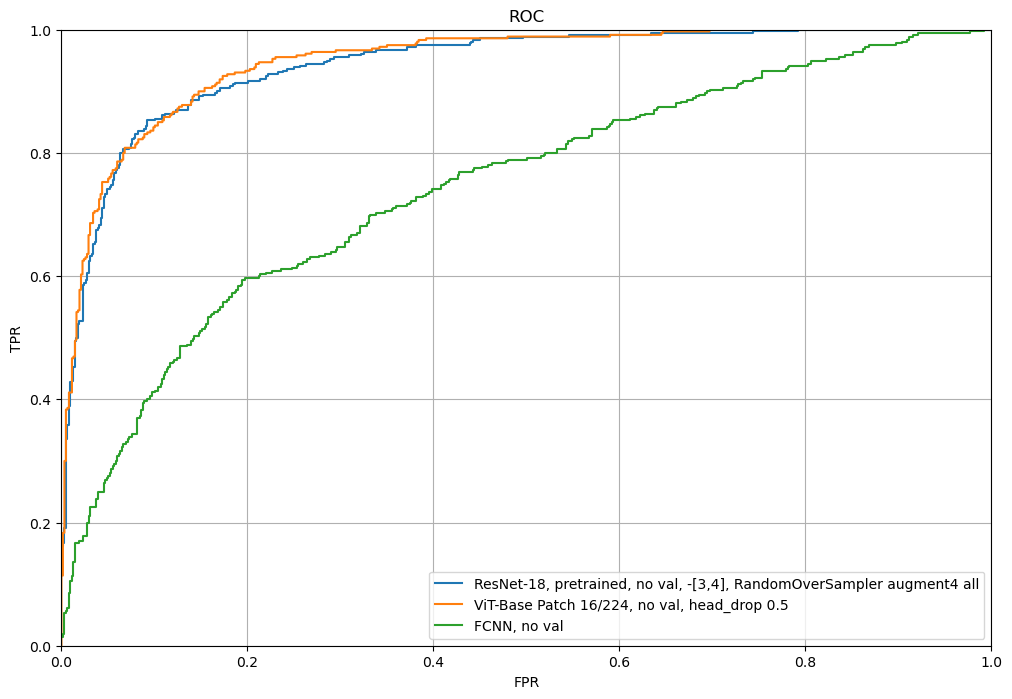

In [87]:
# Summarize and plot test results

######### ResNet-18 ##########

# Random initialization
# model_idx = [0, 1, 3, 4, 5, 6, 7] # Different augmentations
# model_idx = [0, 37, 38, 36] # Removing different annotators
#model_idx = [0, 4, 82, 35] # Augmentation with/without -[3,4] and -[4]
# model_idx = [0, 40, 44, 47, 41] # RandomOverSampler, SMOTE, ADASYN, RandomOverSampler augment all - compare levels of augmentation, does simple oversampling help?
# model_idx = [0, 41, 42, 43, 51] # Different flavors of RandomOverSampler with augmentation
# model_idx = [0, 47, 48, 49, 50, 52] # Different flavors of ADASYN with augmentation
# model_idx = [0, 41, 48, 42, 49, 43, 50, 51, 52] # ROS and ADASYN with augmentation
# model_idx = [0, 4, 40, 41] # Effect of balancing and augmentation on misclassified distribution
# model_idx = [100, 104, 140, 141] # Effect of balancing and augmentation on misclassified distribution
# model_idx = [0, 4, 82, 43, 49] # Best of

# Pretrained
# model_idx = [100, 101, 103, 104] # Different augmentations
# model_idx = [100, 141, 143] # RandomOverSampler with augmentation
# model_idx = [100, 104, 182, 143, 149] # "Best of" - based on the results with random initialization

# Both
# model_idx = [0, 1, 3, 4, 5, 6, 7, 100, 101, 103, 104] # Different augmentations

# Summary
# model_idx = [0, 100] # random init vs pretrained
# model_idx = [4, 104] # paper
# model_idx = [0, 43, 143]

# No validation
# model_idx = [43, '43a']
# model_idx = [143, '143a']
# model_idx = ['43a', '143a']
# model_idx = [43, '43a', 143, '143a']
# model_idx = [143, '143-1']


############### ViT #################

# model_idx = ['143a', '221-nv'] # best CNN vs. best ViT

# model_idx = ['221-nv-rs102', '221-nv-rs435', '221-nv-rs860', '221-nv-rs270', '221-nv-rs106', '221-nv-rs71', '221-nv-rs700', '221-nv-rs20', '221-nv-rs614', '221-nv-rs42'] # 10 random seeds

model_idx = ['143a', '221-nv', 'ensemble']


############### FCNN #################

model_idx = ['143a', '221-nv', '300-nv']

# augment4 means using flip+rotate (model4)
# augment4 all means augment all samples
# -[x] means removing samples with x annotator count
# no val means used all training data for training (no validation split)
    # no specification means holdout validation 0.8/0.2
model_num_map = {'model0': 'ResNet-18',
                 'model1': 'ResNet-18, flip 0.5',
                 'model2': 'ResNet-18, rotate 0.2',
                 'model3': 'ResNet-18, rotate 0.5',
                 'model4': 'ResNet-18, flip 0.5, rotate 0.5',
                 'model5': 'ResNet-18, perspective 0.5',
                 'model6': 'ResNet-18, affine 0.5',
                 'model7': 'ResNet-18, flip 0.5, (rotate/perspective/affine) 0.5',
                 'model20': 'ResNet-18, WeightedRandomSampler',
                 'model21': 'ResNet-18, weighted BCE loss',
                 'model35': 'ResNet-18, -[4], augment4 all',
                 'model36': 'ResNet-18, -[4]',
                 'model37': 'ResNet-18, -[3]',
                 'model38': 'ResNet-18, -[3,4]',
                 'model82': 'ResNet-18, -[3,4], augment4 all',
                 'model40': 'ResNet-18, RandomOverSampler',
                 'model41': 'ResNet-18, RandomOverSampler augment4 all',
                 'model42': 'ResNet-18, -[3], RandomOverSampler augment4 all',
                 'model43': 'ResNet-18, -[3,4], RandomOverSampler augment4 all',
                 'model43a': 'ResNet-18, no val, -[3,4], RandomOverSampler augment4 all',
                 'model44': 'ResNet-18, SMOTE',
                 'model47': 'ResNet-18, ADASYN',
                 'model48': 'ResNet-18, ADASYN augment4 all',
                 'model49': 'ResNet-18, -[3], ADASYN augment4 all',
                 'model50': 'ResNet-18, -[3,4], ADASYN augment4 all',
                 'model51': 'ResNet-18, -[4], RandomOverSampler augment4 all',
                 'model52': 'ResNet-18, -[4], ADASYN augment4 all',
                 'model53': 'ResNet-18, -[3,4], RandomOverSampler augment7 all',
                 'model80': 'ResNet-18, flip 0.5, rotate 0.5, WeightedRandomSampler',
                 
                 'model100': 'ResNet-18, pretrained',
                 'model101': 'ResNet-18, pretrained, flip 0.5',
                 'model102': 'ResNet-18, pretrained, rotate 0.2',
                 'model103': 'ResNet-18, pretrained, rotate 0.5',
                 'model104': 'ResNet-18, pretrained, flip 0.5, rotate 0.5',
                 'model120': 'ResNet-18, pretrained, WeightedRandomSampler',
                 'model121': 'ResNet-18, pretrained, weighted BCE loss',
                 'model140': 'ResNet-18, pretrained, RandomOverSampler',
                 'model141': 'ResNet-18, pretrained, RandomOverSampler augment4 all',
                 'model142': 'ResNet-18, pretrained, -[3], RandomOverSampler augment4 all',
                 'model143': 'ResNet-18, pretrained, -[3,4], RandomOverSampler augment4 all',
                 'model143a': 'ResNet-18, pretrained, no val, -[3,4], RandomOverSampler augment4 all',
                 'model143-1': 'Second run of model143; sanity check after adding multiclass support',
                 'model143-2': 'ResNet-18, pretrained, -[3,4], RandomOverSampler augment4 all, grad_accum=4',
                 'model144': 'ResNet-18, pretrained, SMOTE',
                 'model147': 'ResNet-18, pretrained, ADASYN',
                 'model148': 'ResNet-18, pretrained, ADASYN augment4 all',
                 'model149': 'ResNet-18, pretrained, -[3], ADASYN augment4 all',
                 'model150': 'ResNet-18, pretrained, -[3,4], ADASYN augment4 all',
                 'model180': 'ResNet-18, pretrained, flip 0.5, rotate 0.5, WeightedRandomSampler',
                 'model182': 'ResNet-18, pretrained, -[3,4], augment4 all',
                 
                 # These are all pretrained, -[3,4], RandomOverSampler augment4 all
                 'model200': 'ViT-Base Patch16/224, lr_init 1e-5, lr_decay 0.91/epoch, ebs 8, first run', # ebs = effective batch size
                 'model200-1': 'Second run of model200; sanity check run-to-run',

                 # Everything after this uses random seed 42
                 'model200-2': 'ViT-Base Patch16/224, lr_init 1e-5, lr_decay 0.91/epoch, ebs 8',
                 
                 # Effective batch size experiments
                 'model200a': 'ViT-Base Patch16/224, lr_init 1e-5, lr_decay 0.91/epoch, ebs 16',
                 'model200b': 'ViT-Base Patch16/224, lr_init 1e-5, lr_decay 0.91/epoch, ebs 32',

                 # Learning rate experiments
                 'model201': 'ViT-Base Patch16/224, lr 1e-5',
                 'model201a': 'ViT-Base Patch16/224, lr 5e-5',
                 'model201b': 'ViT-Base Patch16/224, lr 1e-6',

                 # Dropout experiments
                 # Same setup as model200
                 'model220': 'ViT-Base Patch 16/224, head_drop 0.3',
                 'model220-1': 'Same as model220 but patience=25',
                 'model221': 'ViT-Base Patch 16/224, head_drop 0.5',
                 'model221a': 'ViT-Base Patch 16/224, head_drop 0.3',
                 'model221-nv': 'ViT-Base Patch 16/224, no val, head_drop 0.5',
                 'model222': 'ViT-Base Patch 16/224, head_drop 0.5, blocks[11].mlp drop 0.5', # includes head_drop, all drop in blocks[11].mlp
                 'model223': 'ViT-Base Patch 16/224, head_drop 0.5, blocks[11] drop 0.5', # includes all following layers, all drop in blocks[11]
                 'model224': 'ViT-Base Patch 16/224, head_drop 0.5, blocks[10:11] drop 0.5', # includes head_drop
                 'model224a': 'ViT-Base Patch 16/224, head_drop 0.3, blocks[10:11] drop 0.3', # includes head_drop
                 'model225': 'ViT-Base Patch 16/224, head_drop 0.5, blocks[7:11] drop 0.5', # includes head_drop
                 'model226': 'ViT-Base Patch 16/224, head_drop 0.5, blocks[3:11] drop 0.5', # includes head_drop

                 'model230': 'ViT-Base Patch 16/224, pos_drop 0.5',
                 'model230a': 'ViT-Base Patch 16/224, pos_drop 0.2',

                 # Weight decay experiments
                 # Same setup as model200 except using AdamW optimizer
                 'model240': 'ViT-Base Patch 16/224, no weight decay', # for testing for difference b/w Adam and AdamW optimizers
                 'model240a': 'ViT-Base Patch 16/224, weight decay 1e-4',
                 'model240b': 'ViT-Base Patch 16/224, weight decay 1e-3',
                 'model240c': 'ViT-Base Patch 16/224, weight decay 1e-2',
                 'model240d': 'ViT-Base Patch 16/224, weight decay 0.1',
                 'model240e': 'ViT-Base Patch 16/224, weight decay 1',
                 'model240f': 'ViT-Base Patch 16/224, weight decay 10',

                 # Best model, 10 random seeds
                 'model221-nv-rs102': 'ViT-Base Patch 16/224, no val, head_drop 0.5, randseed 102',
                 'model221-nv-rs435': 'ViT-Base Patch 16/224, no val, head_drop 0.5, randseed 435',
                 'model221-nv-rs860': 'ViT-Base Patch 16/224, no val, head_drop 0.5, randseed 860',
                 'model221-nv-rs270': 'ViT-Base Patch 16/224, no val, head_drop 0.5, randseed 270',
                 'model221-nv-rs106': 'ViT-Base Patch 16/224, no val, head_drop 0.5, randseed 106',
                 'model221-nv-rs71': 'ViT-Base Patch 16/224, no val, head_drop 0.5, randseed 71',
                 'model221-nv-rs700': 'ViT-Base Patch 16/224, no val, head_drop 0.5, randseed 700',
                 'model221-nv-rs20': 'ViT-Base Patch 16/224, no val, head_drop 0.5, randseed 20',
                 'model221-nv-rs614': 'ViT-Base Patch 16/224, no val, head_drop 0.5, randseed 614',
                 'model221-nv-rs42': 'ViT-Base Patch 16/224, no val, head_drop 0.5, randseed 42',


                 'modelensemble': 'ResNet model143a + ViT model221-nv',



                 
                 # Exact same configuration as best ResNet-18 except for preprocessing normalization
                 'model300': 'FCNN',
                 'model300-nv': 'FCNN, no val',
                 'model301': 'FCNN, lr 1e-3, no lr scheduler',
                }

model_idx_str = ['model' + str(mdx) for mdx in model_idx]
# model_idx = list(test_outputs.keys())
# model_idx.sort()
print(model_idx_str)
cols = list(test_outputs[model_idx_str[0]].keys())

df_dict = {key: [] for key in cols}
if 'True Labels' in df_dict:
    df_dict.pop('True Labels')
    df_dict.pop('Probabilities')
    df_dict.pop('Predictions')
for mdx in model_idx_str:
    for col in cols:
        if col in ['True Labels', 'Probabilities', 'Predictions']:
            continue
        if col in test_outputs[mdx]:
            df_dict[col].append(test_outputs[mdx][col])
        else:
            df_dict[col].append([])

# rocs = df_dict['BinaryROC']
# del df_dict['BinaryROC']
rocs = df_dict.pop('BinaryROC')
misclassifieds = df_dict.pop('misclassified')

for key in df_dict:
    df_dict[key] = np.round(np.array(df_dict[key]),3)

df_dict['Model'] = model_idx_str

df_test_results = pd.DataFrame(df_dict)
df_test_results['Model'] = df_test_results['Model'].map(model_num_map)
df_test_results = df_test_results.set_index('Model')

plt.figure(figsize=(12,8))
aucs = np.zeros(len(model_idx_str))
for mdx in range(len(model_idx_str)):
    fpr, tpr, thresholds = rocs[mdx]
    auc = torch.trapz(tpr, fpr)
    aucs[mdx] = auc.cpu().numpy()
    fpr = fpr.cpu().numpy()
    tpr = tpr.cpu().numpy()
    #bin_size = np.diff(fpr)
    #auc = np.trapz(tpr, fpr)
    #aucs[mdx] = auc
    #print(sum(tpr[1:]*bin_size), auc)
    plt.plot(fpr, tpr, label=model_num_map[model_idx_str[mdx]])

df_test_results['AUC Manual Calc'] = np.round(aucs,3)

plt.legend(loc='lower right')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()

df_test_results

In [ ]:
# Plot the distribution of misclassified samples

model_idx_str = ['model' + str(mdx) for mdx in model_idx]
for mdx in range(len(model_idx_str)):
#     x = list(anno_counts.keys())
# y = np.array(list(anno_counts.values()))

    misclassified = misclassifieds[mdx]
    if misclassified == []:
        continue
    x = list(misclassified.keys())
    y = np.array(list(misclassified.values()))
    plt.figure(figsize=(10,6))
    sns.barplot(x = x, y = y/np.sum(y)*100)
    plt.xlabel('Annotator Count')
    plt.ylabel('Normalized Count (%)')
    plt.title('Misclassified Samples, ' + model_num_map[model_idx_str[mdx]])
    plt.grid()

In [ ]:
# Compare training results

# Random initialization
# model_idx = [0, 1, 3, 4, 5, 6, 7] # Different augmentations
# model_idx = [0, 37, 38, 36] # Removing different annotators
# model_idx = [0, 4, 82, 35] # Augmentation with/without -[3,4] and -[4]
# model_idx = [0, 40, 44, 47, 41] # RandomOverSampler, SMOTE, ADASYN, RandomOverSampler augment all - compare levels of augmentation, does simple oversampling help?
# model_idx = [0, 41, 42, 43, 51] # Different flavors of RandomOverSampler with augmentation
# model_idx = [0, 47, 48, 49, 50, 52] # Different flavors of ADASYN with augmentation
# model_idx = [0, 41, 48, 42, 49, 43, 50, 51, 52]
# model_idx = [0, 4, 82, 43, 49] # Best of

# Pretrained
# model_idx = [100, 101, 103, 104] # Different augmentations
# model_idx = [100, 141, 143] # RandomOverSampler with augmentation
# model_idx = [100, 104, 182, 143, 149] # "Best of" - based on the results with random initialization

# Both
#model_idx = [0, 1, 3, 4, 5, 6, 7, 100, 101, 103, 104] # Different augmentations

# Summary
#model_idx = [0, 100] # random init vs pretrained
#model_idx = [4, 104] # paper
# model_idx = [0, 43, 143]

# No validation
# model_idx = [43, '43a']
# model_idx = [143, '143a']
# model_idx = [43, '43a', 143, '143a']
# model_idx = [143, '143-1']


############### ViT #################

# model_idx = [143, '200-2'] # best CNN vs. first ViT
# model_idx = [200, '200-1', '200-2'] # random seed 42
# model_idx = ['200-2', '200a', '200b'] # batch size experiments
# model_idx = ['200-2', 201, '201a', '201b'] # lr experiments
# model_idx = ['200-2', 220, 221, 222, 223, 224, '224a', 225, 226] # dropout experiments (starting from head)
# model_idx = ['200-2', 230, '230a'] # pos_drop
# model_idx = ['200-2', 220, 221, 222, 223, 224, '224a', 225, 226, 230, '230a'] # all dropout experiments
# model_idx = ['200-2', 221, 224, '224a'] # select dropout experiments
# model_idx = ['200-2', 240, '240a', '240b', '240d', '240e', '240f'] # weight decay experiments



############### FCNN #################

model_idx = [300, 301]


yminf1 = 0

f1 = plt.figure(figsize=(12,8))
f2 = plt.figure(figsize=(12,8))
f3 = plt.figure(figsize=(12,8))
f4 = plt.figure(figsize=(12,8))
f5 = plt.figure(figsize=(12,8))
f6 = plt.figure(figsize=(12,8))
f7 = plt.figure(figsize=(12,8))
f8 = plt.figure(figsize=(12,8))
f9 = plt.figure(figsize=(12,8))
cdx = 0
colorkeys = list(mcd.CSS4_COLORS.keys())
colorkeys = [key for key in colorkeys if 'dark' in key]
dict_train_results = {'Model': [], 'Best Epoch': [], 'Train Loss': [], 'Val Loss': [], 'Train AUC': [], 'Val AUC': [], 'Train F1': [], 'Val F1': []}
for mdx in model_idx:
    model_str = 'model' + str(mdx)
    with open(model_str + '_train_results.pkl', 'rb') as f:
        train_output = pickle.load(f)
    
    epochs = len(train_output['T Loss'])
    best_epoch = train_output['Best Epoch']
    
    plt.figure(f1.number)
    plt.plot(list(range(1,epochs+1)), np.array(train_output['T Loss'][:epochs]), label='train ' + model_num_map[model_str])

    plt.figure(f4.number)
    plt.plot(list(range(1,epochs+1)), np.array(train_output['V Loss'][:epochs]), label='val ' + model_num_map[model_str])

    plt.figure(f3.number)
    plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryF1Score'][:epochs]), label='train ' + model_num_map[model_str])

    plt.figure(f2.number)
    plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryF1Score'][:epochs]), label='val ' + model_num_map[model_str])

    if 'T BinaryROC' in train_output:
        plt.figure(f7.number)
        plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryROC'][:epochs]), label='train ' + model_num_map[model_str])
    
        plt.figure(f8.number)
        plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryROC'][:epochs]), label='val ' + model_num_map[model_str])

    plt.figure(f5.number)
    plt.plot(list(range(1,epochs+1)), np.array(train_output['T Loss'][:epochs]), label='train ' + model_num_map[model_str])
    plt.plot(list(range(1,epochs+1)), np.array(train_output['V Loss'][:epochs]), label='val ' + model_num_map[model_str])

    plt.figure(f6.number)
    plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryF1Score'][:epochs]), label='train ' + model_num_map[model_str])
    plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryF1Score'][:epochs]), label='val ' + model_num_map[model_str])

    if 'T BinaryROC' in train_output:
        plt.figure(f9.number)
        plt.plot(list(range(1,epochs+1)), np.array(train_output['T BinaryROC'][:epochs]), label='train ' + model_num_map[model_str])
        plt.plot(list(range(1,epochs+1)), np.array(train_output['V BinaryROC'][:epochs]), label='val ' + model_num_map[model_str])

    dict_train_results['Model'].append(model_str)
    dict_train_results['Best Epoch'].append(best_epoch)
    dict_train_results['Train Loss'].append(np.round(train_output['T Loss'][best_epoch-1],1))
    dict_train_results['Val Loss'].append(np.round(train_output['V Loss'][best_epoch-1],1))
    dict_train_results['Train F1'].append(np.round(train_output['T BinaryF1Score'][best_epoch-1],3))
    dict_train_results['Val F1'].append(np.round(train_output['V BinaryF1Score'][best_epoch-1],3))
    if 'T BinaryROC' in train_output:
        dict_train_results['Train AUC'].append(np.round(train_output['T BinaryROC'][best_epoch-1],3))
        dict_train_results['Val AUC'].append(np.round(train_output['V BinaryROC'][best_epoch-1],3))
    else:
        dict_train_results['Train AUC'].append(np.nan)
        dict_train_results['Val AUC'].append(np.nan)

plt.figure(f1.number)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()

plt.figure(f4.number)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()

plt.figure(f3.number)
plt.title('Training F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.ylim([yminf1, 1])
plt.grid()

plt.figure(f2.number)
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.ylim([yminf1, 1])
plt.grid()

plt.figure(f7.number)
plt.title('Training AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.grid()

plt.figure(f8.number)
plt.title('Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.grid()

plt.figure(f5.number)
plt.title('Training+Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()

plt.figure(f6.number)
plt.title('Training+Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.ylim([yminf1, 1])
plt.grid()

plt.figure(f9.number)
plt.title('Training+Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.grid()

df_train_results = pd.DataFrame(dict_train_results)
df_train_results['Model'] = df_train_results['Model'].map(model_num_map)
df_train_results = df_train_results.set_index('Model')
df_train_results

# Define gain and lift calculators

In [89]:
# Gain and lift functions

def calc_lift(y_prob, y_pred, y_actual, bins):
    # y_prob = probability that y = 1
    # y_pred = prediction
    # y = true label
    # bins = number of bins

    # Generate model results dataframe
    cols = ['actual','pred_proba','pred']
    # data = [y_actual, y_prob[:,1] ,y_pred]
    data = [y_actual, y_prob, y_pred]
    df = pd.DataFrame(dict(zip(cols,data)))

    # Observations where y=1
    total_positive_n = df['actual'].sum()

    # Total Observations
    total_obs = df.shape[0]

    # Baseline positive rate
    baseline_positive_r = total_positive_n / float(total_obs)

    # Create N deciles (Decile 1: highest prob --> Decile 10: lowest prob)
    # The 'deciles' column contains the decile number for each sample
    df['deciles'] = pd.qcut(df['pred_proba'], bins, labels=False)

    # Reverse the decile number so that high probability has lower index number
    df['deciles'] = bins - df['deciles']
    #print(df)
    '''
    Calculate lift by decile
    '''
    # Calculate decile level positive rate
    #lift_df = df.groupby('deciles').agg({'actual': [np.mean, np.sum, len]})
    lift_df = df.groupby('deciles').agg({'actual': ['mean', 'sum', len]})
    lift_df = lift_df.rename(columns={'actual': 'output_labels'})
    lift_df = lift_df.rename(columns={'mean': 'pos_rate', 'sum': 'num_pos', 'len': 'num_samps'}, level=1)
    
    # lift_df['cumsum_rate'] = lift_df['cum_num_pos'] / lift_df['output_labels']['num_pos'].sum()
    # lift_df['lift'] = lift_df['output_labels']['pos_rate'] / (lift_df['output_labels']['num_pos'].sum() / lift_df['output_labels']['num_samps'].sum())
    # lift_df['baseline_positive_rate'] = lift_df['output_labels']['num_pos'].sum() / lift_df['output_labels']['num_samps'].sum()

    lift_df.reset_index(level=0, inplace=True)
    lift_df['cum_num_pos'] = lift_df['output_labels']['num_pos'].cumsum()

    # Gain is the percentage of positive samples in the top X deciles
    # For example, in the top decile, if we were randomly guessing, we'd get 10% of the positive samples
    # If our gain in the top decile is 60%, our model is getting 60% of the positive samples
    lift_df['gain'] = lift_df['cum_num_pos']/total_positive_n

    # Lift measures how much better our model is than randomly guessing
    # For a given decile, lift = (positive rate)/(baseline rate)
    lift_df['lift'] = lift_df['output_labels']['pos_rate']/baseline_positive_r

    # Cumulative lift also measures how much better our model is than randomly guessing, but it's cumulative
    # For the top X deciles, cumulative lift = (cumulative positive rate)/(baseline rate)
    lift_df['cum_lift'] = (lift_df['cum_num_pos']/lift_df['output_labels']['num_samps'].cumsum())/baseline_positive_r
    
    # Relationships b/w gain, lift, and cum lift
    #lift_df['cum_lift2'] = lift_df['gain']*bins/lift_df['deciles']
    #lift_df['cum_lift3'] = lift_df['lift'].cumsum()/lift_df['deciles']

    lift_df['baseline_positive_rate'] = baseline_positive_r
    
    return lift_df

def plot_lift_chart(dfs: list[pd.DataFrame], labels: list[str], bins: int):
    f_lift = plt.figure(figsize=(12,8))
    f_cum_lift = plt.figure(figsize=(12,8))
    f_gain = plt.figure(figsize=(12,8))

    for ddx, df in enumerate(dfs):
        plt.figure(f_lift.number)
        if ddx == 0:
            plt.plot(df['deciles'], np.ones(df.shape[0]), label='Random guessing')
        plt.plot(df['deciles'], df['lift'], marker='o', label=labels[ddx])

        plt.figure(f_cum_lift.number)
        if ddx == 0:
            plt.plot(df['deciles'], np.ones(df.shape[0]), label='Random guessing')
        plt.plot(df['deciles'], df['cum_lift'], marker='o', label=labels[ddx])

        plt.figure(f_gain.number)
        if ddx == 0:
            plt.plot(df['deciles'], np.array(range(1,bins+1))/bins, label='Random guessing')   
        plt.plot(df['deciles'], df['gain'], marker='o', label=labels[ddx])

    x_tick_marks = np.arange(bins) + 1
    
    plt.figure(f_lift.number)
    plt.xticks(x_tick_marks)
    plt.ylim(bottom=0)
    plt.xlim((1,bins))
    plt.xlabel('Bin', size=12)
    plt.ylabel('Lift', size=12)
    plt.title('Lift')
    plt.legend(loc='best')
    plt.grid()

    plt.figure(f_cum_lift.number)
    plt.xticks(x_tick_marks)
    plt.ylim(bottom=0)
    plt.xlim((1,bins))
    plt.xlabel('Bin', size=12)
    plt.ylabel('Cumulative Lift', size=12)
    plt.title('Cumulative Lift')
    plt.legend(loc='best')
    plt.grid()

    plt.figure(f_gain.number)
    plt.xticks(x_tick_marks)
    plt.ylim(bottom=0)
    plt.xlim((1,bins))
    plt.xlabel('Bin', size=12)
    plt.ylabel('Gain', size=12)
    plt.title('Gain')
    plt.legend(loc='best')
    plt.grid()

# Plot lift and gain

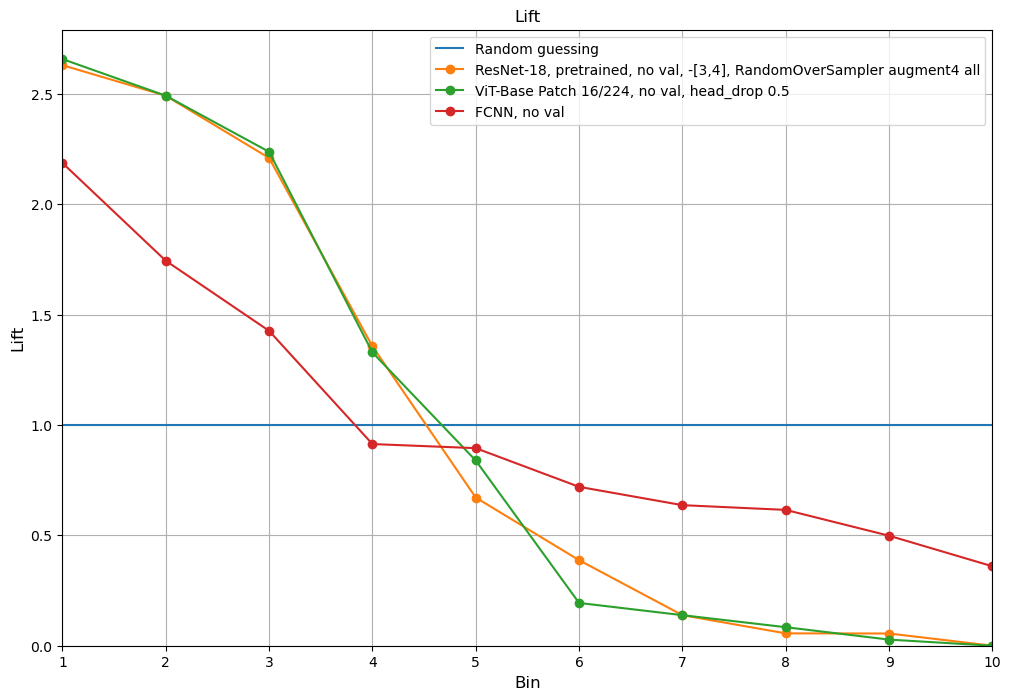

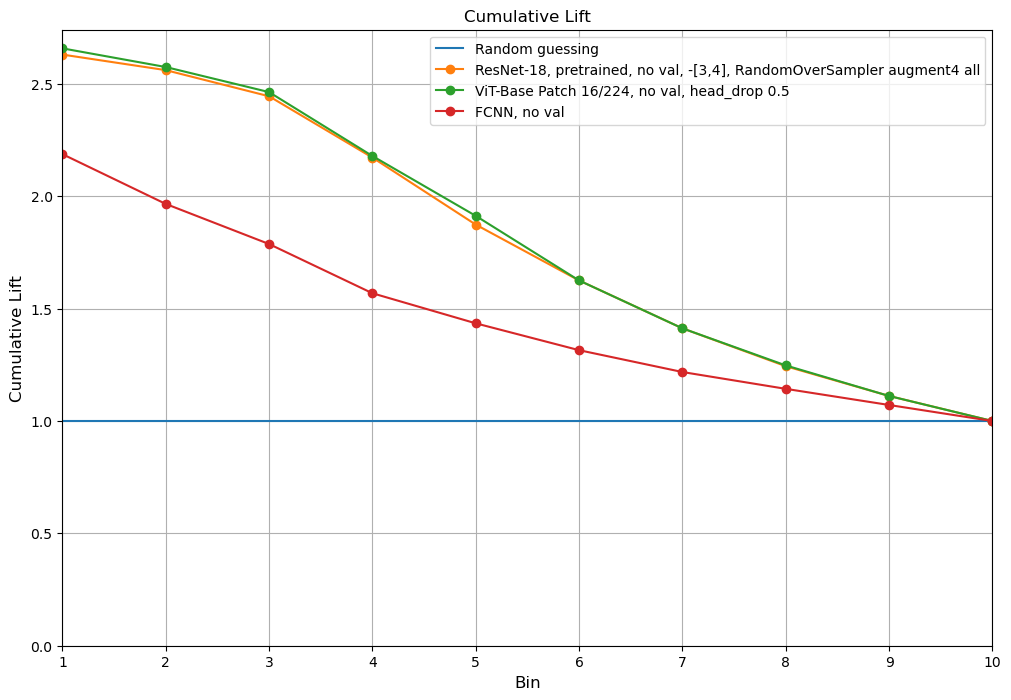

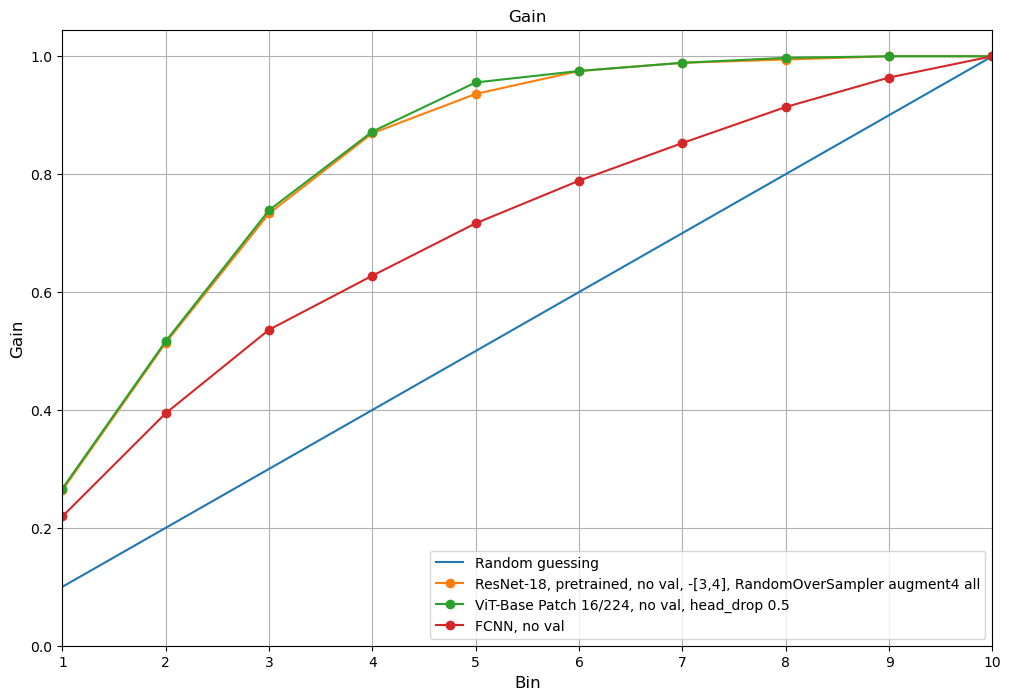

In [90]:
bins = 10

model_idx = ['143a', '221-nv', '300-nv']


model_idx_str = ['model' + str(mdx) for mdx in model_idx]

dfs_lift = []
for mdx in model_idx_str:
    y = test_outputs[mdx]['True Labels']
    y_prob = test_outputs[mdx]['Probabilities']
    y_pred = test_outputs[mdx]['Predictions']
    dfs_lift.append(calc_lift(y_prob, y_pred, y, bins))

labels = [model_num_map[mdx] for mdx in model_idx_str]
plot_lift_chart(dfs_lift, labels, bins)

In [ ]:
import matplotlib._color_data as mcd
colorkeys = list(mcd.CSS4_COLORS.keys())
colorkeys = [key for key in colorkeys if 'dark' in key]
colorkeys

In [ ]:
tpr1 = np.ones(len(fpr))
tpr1 = fpr
auc = np.trapz(tpr1, fpr)
auc

In [ ]:
thresholds = thresholds.cpu()
plt.figure()
plt.plot(thresholds)
len(thresholds)

In [ ]:
bin_size = np.diff(fpr)
# bin_size = bin_size[np.nonzero(bin_size)]
# print(bin_size.min())
# print(bin_size.max())
# print(bin_size.mean())
sum(tpr[1:]*bin_size)

In [ ]:
batch = next(iter(train_loader))
batch.keys()

In [ ]:
image_path = batch['image_path'][0]
image_path

In [ ]:
image = skimage.io.imread(image_path)
print(type(image))
image.shape

In [ ]:
figure = plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(image)

In [ ]:
# transform_augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
# ])

# transform_augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomApply([transforms.RandomRotation(degrees=180, expand=True),
#                             transforms.Resize(size=224, interpolation=InterpolationMode.BILINEAR)], p=0.5),
# ])

# transform_augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomRotation(degrees=180, expand=True),
#     transforms.Resize(size=224, interpolation=InterpolationMode.BILINEAR)
# ])

# transform_augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomPerspective(distortion_scale=0.5, interpolation=InterpolationMode.BILINEAR, p=1.0)
# ])

transform_augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), shear=(-15,15,-15,15), scale=(0.5,0.55), interpolation=InterpolationMode.BILINEAR)
])

transform_augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=180, expand=True),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), shear=(-15,15,-15,15), scale=(0.5,0.55), interpolation=InterpolationMode.BILINEAR),
    transforms.Resize(size=224, interpolation=InterpolationMode.BILINEAR),
])

# transform_augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomChoice([
#         transforms.RandomApply([transforms.RandomRotation(degrees=180, expand=True),
#                                 transforms.Resize(size=224, interpolation=InterpolationMode.BILINEAR)], p=0.5),
#         transforms.RandomPerspective(distortion_scale=0.5, interpolation=InterpolationMode.BILINEAR, p=0.5),
#         transforms.RandomApply([transforms.RandomAffine(degrees=5, translate=(0.1,0.1), 
#                                                         shear=(-15,15,-15,15), scale=(0.5,0.55), 
#                                                         interpolation=InterpolationMode.BILINEAR)], p=0.5),
#     ])
# ])

image_augment = transform_augment(image)
totensor = transforms.ToTensor()
print(totensor(image_augment).shape)
figure = plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(image_augment)